In [61]:
import trenchripper as tr

import csv
import copy
import ast
import re
import glob
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import skimage as sk
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import FuncFormatter


from Bio import SeqIO
from Bio.Seq import Seq
from Bio import GenBank

from matplotlib import pyplot as plt

## Load Functions

In [32]:
# Function to format the ticks
def format_1000(x, pos):
    return f'{x / 1000:.1f}'

# Function to format the ticks
def format_100000(x, pos):
    return f'{x / 100000:.1f}'

# mode-finding 
def hrm_find_mode(series, max_iter=1000, min_binsize=50):
    working_series = series
    for i in range(max_iter):
        range_max,range_min = np.max(working_series),np.min(working_series)
        midpoint = (range_max+range_min)/2
        above_middle = working_series[working_series>midpoint]
        below_middle = working_series[working_series<=midpoint]
        
        count_above = len(above_middle)
        count_below = len(below_middle)
        
        
        if count_above>count_below:
            working_series = above_middle
        else:
            working_series = below_middle
        
        if i > 0:
            if (len(working_series)<min_binsize) or (last_midpoint==midpoint):
                return np.mean(working_series)

        last_midpoint = midpoint

def lookup_variant(variant_library_path,channel,varid,trench_indices):
    path_prefix = variant_library_path + "/" + str(varid) + "_"
    variant_files = glob.glob(path_prefix + '*')
    n_files = len(variant_files)
    img_arr = []
    for i in range(n_files):
        variant_file = path_prefix + str(i) + ".hdf5"
        with h5py.File(variant_file,"r") as infile:
            data = infile[channel][trench_indices]
            img_arr.append(data)
    img_arr = np.concatenate(img_arr,axis=1)
    return img_arr

## Load Data

In [39]:
agg_marker_frequency_df_circ = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Marker_Frequency_Analysis/Marker_Frequencies_100kb_CircularRef.csv",index_col=["Strain","Condition","Ref Bin"])

all_fcs_data_df = pd.read_csv("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Replication_Runout/Replication_Runout.csv",index_col=["Strain","Condition","Replicate"])

ss_estimator_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
ss_estimator_df = ss_estimator_df.loc["Mean (Robust)"]
ss_length_estimator_df = ss_estimator_df.loc["Length"]

## Figure S10A

In [37]:
#style for kymographs
channel_1="mCherry"
channel_2="YFP"
min_intensity_green = 0
max_intensity_green = 15000
min_intensity_magenta = 0
max_intensity_magenta = 50000
green_weight = 1
magenta_weight = 0.8
seg_thickness = 1

t_step = 1
t_i = 45
t_f = 60

yrange = (120,280)

scale_bar_size_um = 10
scale_bar_thickness = 4
scalebar_color = 'white'  # Color of the scale bar
scalebar_y_position = 450 # Y-position of the scale bar in data units
scalebar_x_position = 435  # X-position of the scale bar in data units
pixel_microns = 0.10595 # Number of microns per pixel for this experiment (can also find in metadata.hdf5)
scale_bar_size_pixels = scale_bar_size_um//pixel_microns
scalebar_on = True

In [51]:
ss_length_estimator_df[ss_length_estimator_df["Gene"]=="rne"]

,Value,sgRNA,EcoWG1_id,Gene,N Mismatch,Category,TargetID,N Observations,N Observations Proliferating,Estimator-Variable(s)-NTrenches,P-Value,Corrected P-Value,Estimator Variance,CI Width
oDEPool7_id,,,,,,,,,,,,,,
20000,5.90574,GAGCTGACGAGCAATCTCAT,14398.0,rne,1.0,Target,1828,141,NaN,Mean (Robust)-Length-141,0.00002,0.000031,0.00188,0.143691


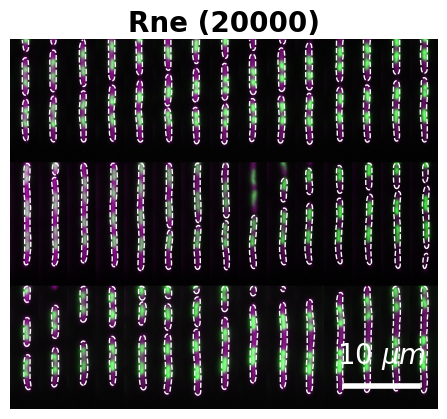

In [66]:
variant_library_path = "/home/de64/scratch/de64/sync_folder/2023-03-11_lDE26_Run_1/Variant_Library"
base_export_path = "/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10"

highlighted_sgrnaid_list = [20000]
highlighted_gene_list = ["rne"]
highlighted_trenches_lists = [[0,4,7]]

for gene_idx,sgrnaid in enumerate(highlighted_sgrnaid_list):
    
    highlighted_sgrna_idx = highlighted_sgrna_idx_list[gene_idx]
    highlighted_trenches_list = highlighted_trenches_lists[gene_idx]
    
    variant_arr_ch1 = lookup_variant(variant_library_path,channel_1,sgrnaid,highlighted_trenches_list)
    variant_concat_arr_ch1 = np.concatenate([variant_arr_ch1[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch1.shape[0])], axis=1)
    variant_arr_ch2 = lookup_variant(variant_library_path,channel_2,sgrnaid,highlighted_trenches_list)
    variant_concat_arr_ch2 = np.concatenate([variant_arr_ch2[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_ch2.shape[0])], axis=1)
    variant_arr_seg = lookup_variant(variant_library_path,"Segmentation",sgrnaid,highlighted_trenches_list)
    ##relabeling the stack, which accounts for a bug
    variant_arr_seg_output = []
    for s in range(variant_arr_seg.shape[0]):
        working_seg_kymo = variant_arr_seg[s]
        working_seg_kymo[working_seg_kymo>0] = working_seg_kymo[working_seg_kymo>0]+(100*s)
        variant_arr_seg_output.append(working_seg_kymo)
    variant_arr_seg = np.stack(variant_arr_seg_output,axis=0)
    variant_concat_arr_seg = np.concatenate([variant_arr_seg[i,:,yrange[0]:yrange[1]] for i in range(variant_arr_seg.shape[0])], axis=1)
    variant_concat_arr_seg = sk.segmentation.relabel_sequential(variant_concat_arr_seg)[0]

    ##time step and flip
    variant_concat_arr_ch1 = variant_concat_arr_ch1[:,::][t_i:t_f:t_step]
    variant_concat_arr_ch2 = variant_concat_arr_ch2[:,::][t_i:t_f:t_step]
    variant_concat_arr_seg = variant_concat_arr_seg[:,::][t_i:t_f:t_step]
    
    gene_name = highlighted_gene_list[gene_idx]

    tr.plot_kymograph_2channel(variant_concat_arr_ch1,variant_concat_arr_ch2,min_intensity_green,max_intensity_green,min_intensity_magenta,max_intensity_magenta,\
                          channel_1_weight=green_weight,channel_2_weight=magenta_weight,seg_kymo=variant_concat_arr_seg,seg_thickness=seg_thickness)

    plt.axis('off')
    if scalebar_on:
        # Draw the scale bar
        plt.plot([scalebar_x_position, scalebar_x_position + scale_bar_size_pixels],
                [scalebar_y_position, scalebar_y_position],
                color=scalebar_color,
                linewidth=scale_bar_thickness)
        # Add a label next to the scale bar
        plt.text(scalebar_x_position + scale_bar_size_pixels / 2,
                scalebar_y_position-60,
                f'{scale_bar_size_um} $\mu m$',
                color=scalebar_color,
                verticalalignment='top',
                horizontalalignment='center',
                fontsize=20)
        plt.title(gene_name[0].capitalize() + gene_name[1:] + " (" + str(sgrnaid) + ")",fontsize=20,weight="bold")
    plt.savefig(base_export_path + "/" + gene_name + "_" + str(sgrnaid) + ".png", bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()

## Figure S10B

/tmp/ipykernel_21045/4065967836.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
/tmp/ipykernel_21045/4065967836.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
/tmp/ipykernel_21045/4065967836.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  stderr_vals = marker_freq_df.loc[strain,condition]["StdErr Log2 Control Ratio"]
/tmp/ipykernel_21045/4065967836.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
/tmp/ipykernel_21045/4065967836.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
/tmp/ipykernel_21045/4065967836.py:11: PerformanceWarning: indexing past 

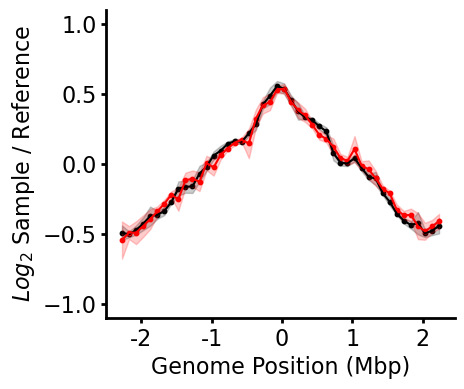

In [17]:
fig = plt.figure(figsize=(4.5,4))
ax = plt.subplot(1,1,1)

strain_condition_list = [("DE19","0Mins"),("DE502","0Mins")]
strain_condition_color_list = ["black","red"]
marker_freq_df = agg_marker_frequency_df_circ

for i,(strain,condition) in enumerate(strain_condition_list):
    position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
    y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
    stderr_vals = marker_freq_df.loc[strain,condition]["StdErr Log2 Control Ratio"]
    strain_condition_color = strain_condition_color_list[i]

    plt.plot(position_vals,y_vals,color=strain_condition_color)
    plt.scatter(position_vals,y_vals,color=strain_condition_color,s=10)

    y_upper = y_vals + 2*stderr_vals
    y_lower = y_vals - 2*stderr_vals
    
    plt.fill_between(position_vals, y_lower, y_upper, color=strain_condition_color, alpha=0.2)
    plt.ylim(-1.1,1.1)
    plt.ylabel(r"$Log_{2}$ Sample / Reference",fontsize=16)
    plt.xlabel(r"Genome Position (Mbp)",fontsize=16)
    plt.xticks([-2000000,-1000000,0,1000000,2000000],[-2,-1,0,1,2],fontsize=16)
    plt.yticks([-1,-0.5,0,0.5,1],fontsize=16)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
# increase tick width
ax.tick_params(width=2)

sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10/30C_NGS_Bins.png",dpi=500,transparent=True,\
           bbox_inches="tight")

/tmp/ipykernel_21045/432967788.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
/tmp/ipykernel_21045/432967788.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
/tmp/ipykernel_21045/432967788.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  stderr_vals = marker_freq_df.loc[strain,condition]["StdErr Log2 Control Ratio"]
/tmp/ipykernel_21045/432967788.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
/tmp/ipykernel_21045/432967788.py:11: PerformanceWarning: indexing past lexsort depth may impact performance.
  y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
/tmp/ipykernel_21045/432967788.py:12: PerformanceWarning: indexing past lexs

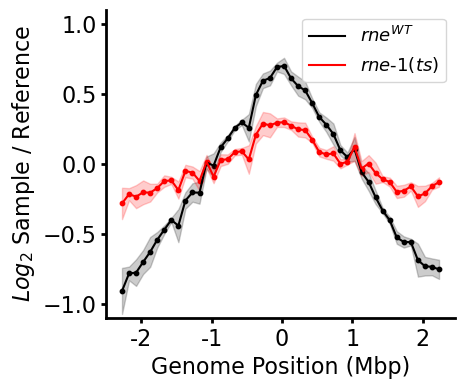

In [18]:
fig = plt.figure(figsize=(4.5,4))
ax = plt.subplot(1,1,1)

strain_condition_list = [("DE19","120Mins"),("DE502","120Mins")]
strain_condition_color_list = ["black","red"]
strain_name_list = [r"$rne^{WT}$",r"$rne$-$1(ts)$"]
marker_freq_df = agg_marker_frequency_df_circ

for i,(strain,condition) in enumerate(strain_condition_list):
    position_vals = marker_freq_df.loc[strain,condition]["Ref Position"]
    y_vals = marker_freq_df.loc[strain,condition]["Mean Log2 Control Ratio"]
    stderr_vals = marker_freq_df.loc[strain,condition]["StdErr Log2 Control Ratio"]
    strain_condition_color = strain_condition_color_list[i]

    plt.plot(position_vals,y_vals,color=strain_condition_color,label=strain_name_list[i])
    plt.scatter(position_vals,y_vals,color=strain_condition_color,s=10)

    y_upper = y_vals + 2*stderr_vals
    y_lower = y_vals - 2*stderr_vals
    
    plt.fill_between(position_vals, y_lower, y_upper, color=strain_condition_color, alpha=0.2)
    plt.ylim(-1.1,1.1)
    plt.ylabel(r"$Log_{2}$ Sample / Reference",fontsize=16)
    plt.xlabel(r"Genome Position (Mbp)",fontsize=16)
    plt.xticks([-2000000,-1000000,0,1000000,2000000],[-2,-1,0,1,2],fontsize=16)
    plt.yticks([-1,-0.5,0,0.5,1],fontsize=16)
plt.legend(fontsize=13,loc='upper right')

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
# increase tick width
ax.tick_params(width=2)

sns.despine()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10/43C_2Hr_NGS_Bins.png",dpi=500,transparent=True,\
           bbox_inches="tight")

## Figure S10C

In [25]:
clipping_range = (3500,262143.0)

succinate_modes = all_fcs_data_df.loc["DE19","Succinate"].groupby("Replicate")["GFP-A"].apply(hrm_find_mode)
succinate_medianofmodes = np.median(succinate_modes)

succinate_ladder = np.stack([succinate_medianofmodes,succinate_medianofmodes*2,succinate_medianofmodes*4,succinate_medianofmodes*8,succinate_medianofmodes*16])

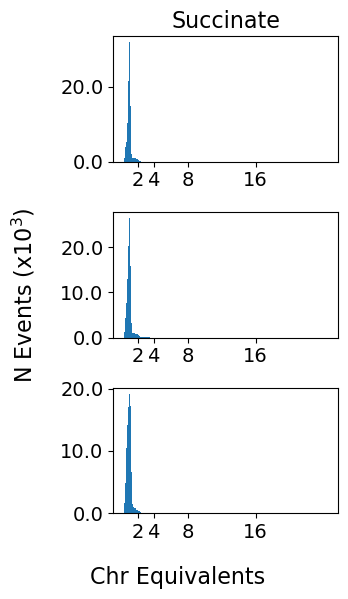

In [29]:
fig = plt.figure(figsize=(3.5,6))
fig.supylabel(r"N Events (x$10^{3}$)",fontsize=16)
fig.supxlabel(r"Chr Equivalents",fontsize=16)

selected_strain = "DE19"
selected_condition = "Succinate"

subplot_idx = 1
for replicate_i in range(1,4):
    ax = plt.subplot(3,1,subplot_idx)
    selected_sample = all_fcs_data_df.loc[selected_strain,selected_condition,replicate_i]
    plt.hist(selected_sample["GFP-A"],bins=200,range=clipping_range,zorder=-8)
    ymax = ax.get_ylim()[1]

    ax.yaxis.set_major_formatter(FuncFormatter(format_1000))
    # ax.xaxis.set_major_formatter(FuncFormatter(format_100000))
    plt.xticks(succinate_ladder[1:],[2,4,8,16])
    ax.tick_params(labelsize=14)
    if replicate_i==1:
        plt.title(r"Succinate",fontsize=16)
    subplot_idx+=1
    
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10/Succinate.png",\
            dpi=500,bbox_inches="tight",transparent=True)

## Figure S10D

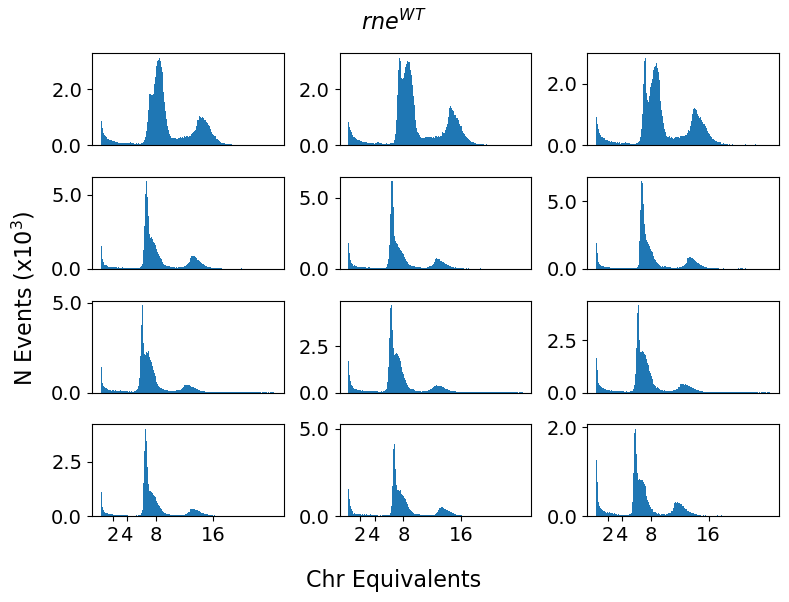

In [30]:
selected_strain = "DE19"
selected_conditions = ["t43=0","t43=30","t43=60","t43=120"]

fig = plt.figure(figsize=(8,6))
fig.supylabel(r"N Events (x$10^{3}$)",fontsize=16)
fig.supxlabel(r"Chr Equivalents",fontsize=16)
fig.suptitle(r"$rne^{WT}$",fontsize=16)

subplot_idx = 1
for condition_i,selected_condition in enumerate(selected_conditions):
    for replicate_i in range(1,4):
        ax = plt.subplot(4,3,subplot_idx)
        selected_sample = all_fcs_data_df.loc[selected_strain,selected_condition,replicate_i]
        plt.hist(selected_sample["GFP-A"],bins=200,range=clipping_range)
        ax.yaxis.set_major_formatter(FuncFormatter(format_1000))
        ax.tick_params(labelsize=14)
        if condition_i!=len(selected_conditions)-1:
            plt.xticks([])
        else:
            plt.xticks(succinate_ladder[1:],[2,4,8,16])
        subplot_idx+=1
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10/DE19_Timeseries.png",\
            dpi=500,bbox_inches="tight",transparent=True)

## Figure S10E

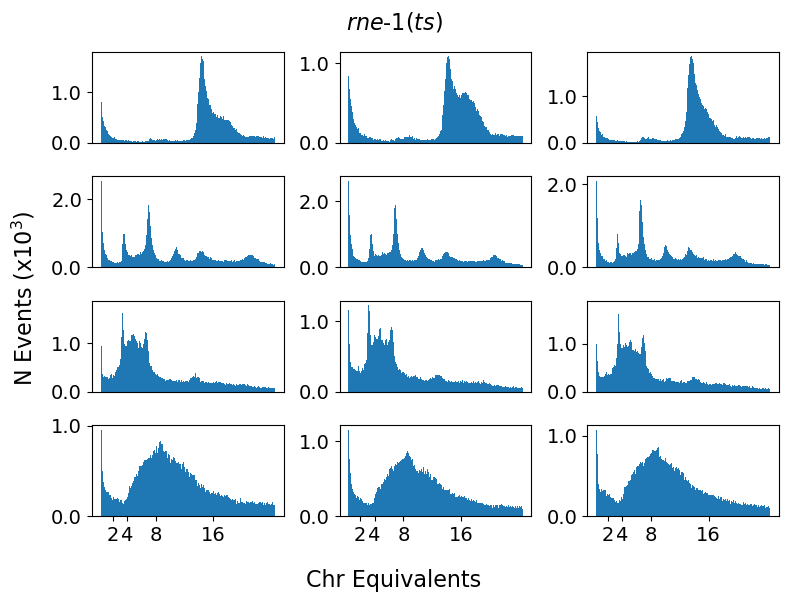

In [31]:
selected_strain = "DE502"
selected_conditions = ["t43=0","t43=30","t43=60","t43=120"]

fig = plt.figure(figsize=(8,6))
fig.supylabel(r"N Events (x$10^{3}$)",fontsize=16)
fig.supxlabel(r"Chr Equivalents",fontsize=16)
fig.suptitle(r"$rne$-$1(ts)$",fontsize=16)

subplot_idx = 1
for condition_i,selected_condition in enumerate(selected_conditions):
    for replicate_i in range(1,4):
        ax = plt.subplot(4,3,subplot_idx)
        selected_sample = all_fcs_data_df.loc[selected_strain,selected_condition,replicate_i]
        plt.hist(selected_sample["GFP-A"],bins=200,range=clipping_range)
        ax.yaxis.set_major_formatter(FuncFormatter(format_1000))
        ax.xaxis.set_major_formatter(FuncFormatter(format_100000))
        ax.tick_params(labelsize=14)
        if condition_i!=len(selected_conditions)-1:
            plt.xticks([])
        else:
            plt.xticks(succinate_ladder[1:],[2,4,8,16])
        subplot_idx+=1
plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/S10/DE502_Timeseries.png",\
            dpi=500,bbox_inches="tight",transparent=True)